In [1]:
# Cargar librerías
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
import mlflow
import mlflow.sklearn


In [5]:
import pandas as pd

# Cargar dataset
df = pd.read_csv('data/credit_risk_dataset.csv')

# Vista general del dataset
print(df.shape)
print(df.dtypes)
print(df.head())
print(df.isnull().sum())


(32581, 12)
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONA

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

print("Valores nulos en 'person_emp_length':", df['person_emp_length'].isnull().sum())

df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)

df['loan_status'] = df['loan_status'].astype(int)

X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Identificar columnas categóricas
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocesamiento: aplicar OneHotEncoder a variables categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough' 
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Valores nulos en 'person_emp_length': 895


C:\Users\adpar\AppData\Local\Temp\ipykernel_3424\422703494.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)


In [8]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Inicia una nueva ejecución de experimento
mlflow.set_tracking_uri("http://127.0.0.1:9090")
mlflow.set_experiment("credit-risk-evaluation")

with mlflow.start_run():
    # Crear pipeline con preprocesador + modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    # Entrenar modelo
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    # Loguear parámetros y métricas
    mlflow.log_param("n_estimators", 100)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)

    # Guardar modelo
    mlflow.sklearn.log_model(pipeline, "model")

    print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}")


2025/05/25 20:03:39 INFO mlflow.tracking.fluent: Experiment with name 'credit-risk-evaluation' does not exist. Creating a new experiment.
2025/05/25 20:03:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy: 0.93, Precision: 0.96, Recall: 0.72
🏃 View run exultant-ox-396 at: http://127.0.0.1:9090/#/experiments/984826277448374756/runs/0fa9f150147341d58d5deb2b0e8ebc58
🧪 View experiment at: http://127.0.0.1:9090/#/experiments/984826277448374756


### Segunda run de prueba

In [15]:
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].median())

df['loan_status'] = df['loan_status'].astype(int)

X = df.drop('loan_status', axis=1)
y = df['loan_status']

cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
num_cols = [col for col in X.columns if col not in cat_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlflow.set_tracking_uri("http://127.0.0.1:9090")
mlflow.set_experiment("credit-risk-evaluation")

C_values = [0.01, 0.1, 1, 10]
solvers = ['liblinear', 'saga']
penalties = ['l1', 'l2']

for C in C_values:
    for solver in solvers:
        for penalty in penalties:
            if solver == 'liblinear' and penalty == 'l1':
                continue

            with mlflow.start_run():
                pipeline = Pipeline([
                    ('preprocessor', preprocessor),
                    ('scaler', StandardScaler()),
                    ('clf', LogisticRegression(
                        C=C,
                        max_iter=1000,
                        solver=solver,
                        penalty=penalty,
                        random_state=42
                    ))
                ])

                pipeline.fit(X_train, y_train)

                y_pred = pipeline.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                prec = precision_score(y_test, y_pred)
                rec = recall_score(y_test, y_pred)

                mlflow.log_param("C", C)
                mlflow.log_param("solver", solver)
                mlflow.log_param("penalty", penalty)
                mlflow.log_metric("accuracy", acc)
                mlflow.log_metric("precision", prec)
                mlflow.log_metric("recall", rec)

                mlflow.sklearn.log_model(pipeline, "model")

                print(f"Run: C={C}, solver={solver}, penalty={penalty} --> Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")


2025/05/25 20:46:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run: C=0.01, solver=liblinear, penalty=l2 --> Accuracy: 0.8621, Precision: 0.7676, Recall: 0.5419
🏃 View run skillful-turtle-779 at: http://127.0.0.1:9090/#/experiments/984826277448374756/runs/784b609f3955433aad5866a942e1a94a
🧪 View experiment at: http://127.0.0.1:9090/#/experiments/984826277448374756


2025/05/25 20:46:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run: C=0.01, solver=saga, penalty=l1 --> Accuracy: 0.8614, Precision: 0.7760, Recall: 0.5273
🏃 View run able-vole-516 at: http://127.0.0.1:9090/#/experiments/984826277448374756/runs/36157ea949c34ea89b91ea116cb0327d
🧪 View experiment at: http://127.0.0.1:9090/#/experiments/984826277448374756


2025/05/25 20:47:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run: C=0.01, solver=saga, penalty=l2 --> Accuracy: 0.8619, Precision: 0.7728, Recall: 0.5343
🏃 View run shivering-flea-688 at: http://127.0.0.1:9090/#/experiments/984826277448374756/runs/673a677228ec404d92c3da26809cc097
🧪 View experiment at: http://127.0.0.1:9090/#/experiments/984826277448374756


2025/05/25 20:47:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run: C=0.1, solver=liblinear, penalty=l2 --> Accuracy: 0.8624, Precision: 0.7671, Recall: 0.5446
🏃 View run unequaled-perch-792 at: http://127.0.0.1:9090/#/experiments/984826277448374756/runs/b1fd518f5f244b72a5de821a7f5a2e2d
🧪 View experiment at: http://127.0.0.1:9090/#/experiments/984826277448374756


2025/05/25 20:47:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run: C=0.1, solver=saga, penalty=l1 --> Accuracy: 0.8625, Precision: 0.7678, Recall: 0.5446
🏃 View run receptive-swan-249 at: http://127.0.0.1:9090/#/experiments/984826277448374756/runs/6c1fe7d649934a53a315a35902de0d0c
🧪 View experiment at: http://127.0.0.1:9090/#/experiments/984826277448374756


2025/05/25 20:47:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run: C=0.1, solver=saga, penalty=l2 --> Accuracy: 0.8624, Precision: 0.7676, Recall: 0.5439
🏃 View run redolent-steed-944 at: http://127.0.0.1:9090/#/experiments/984826277448374756/runs/f28412f4b9ae4759acfcd802dabb0e55
🧪 View experiment at: http://127.0.0.1:9090/#/experiments/984826277448374756


2025/05/25 20:47:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run: C=1, solver=liblinear, penalty=l2 --> Accuracy: 0.8619, Precision: 0.7648, Recall: 0.5446
🏃 View run kindly-croc-23 at: http://127.0.0.1:9090/#/experiments/984826277448374756/runs/c09a54b8abce4d5b9d5c89e9ef6ed1b8
🧪 View experiment at: http://127.0.0.1:9090/#/experiments/984826277448374756


2025/05/25 20:47:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run: C=1, solver=saga, penalty=l1 --> Accuracy: 0.8619, Precision: 0.7648, Recall: 0.5446
🏃 View run invincible-skunk-63 at: http://127.0.0.1:9090/#/experiments/984826277448374756/runs/f584dccade9c478881af89c55aa36c98
🧪 View experiment at: http://127.0.0.1:9090/#/experiments/984826277448374756


2025/05/25 20:47:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run: C=1, solver=saga, penalty=l2 --> Accuracy: 0.8619, Precision: 0.7648, Recall: 0.5446
🏃 View run magnificent-seal-513 at: http://127.0.0.1:9090/#/experiments/984826277448374756/runs/dad5d75ed2b14b65a88dde85efe73c50
🧪 View experiment at: http://127.0.0.1:9090/#/experiments/984826277448374756


2025/05/25 20:47:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run: C=10, solver=liblinear, penalty=l2 --> Accuracy: 0.8619, Precision: 0.7648, Recall: 0.5446
🏃 View run inquisitive-vole-555 at: http://127.0.0.1:9090/#/experiments/984826277448374756/runs/203f2647891146b485b44897db615302
🧪 View experiment at: http://127.0.0.1:9090/#/experiments/984826277448374756


2025/05/25 20:48:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run: C=10, solver=saga, penalty=l1 --> Accuracy: 0.8619, Precision: 0.7648, Recall: 0.5446
🏃 View run debonair-skink-923 at: http://127.0.0.1:9090/#/experiments/984826277448374756/runs/6fbbb742cbdb4d878f295b1332881913
🧪 View experiment at: http://127.0.0.1:9090/#/experiments/984826277448374756


2025/05/25 20:48:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run: C=10, solver=saga, penalty=l2 --> Accuracy: 0.8619, Precision: 0.7648, Recall: 0.5446
🏃 View run fortunate-trout-460 at: http://127.0.0.1:9090/#/experiments/984826277448374756/runs/38817d884ec54265960785a1efc8edc9
🧪 View experiment at: http://127.0.0.1:9090/#/experiments/984826277448374756


# GRAFICAS

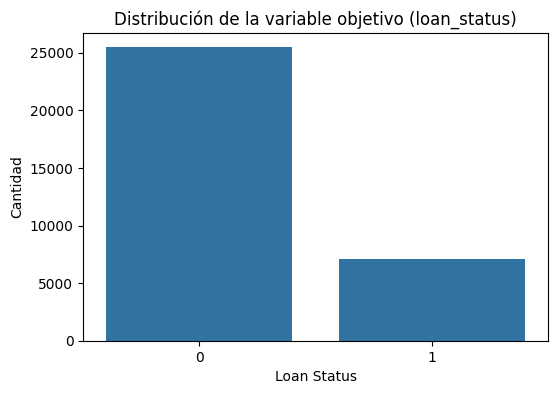

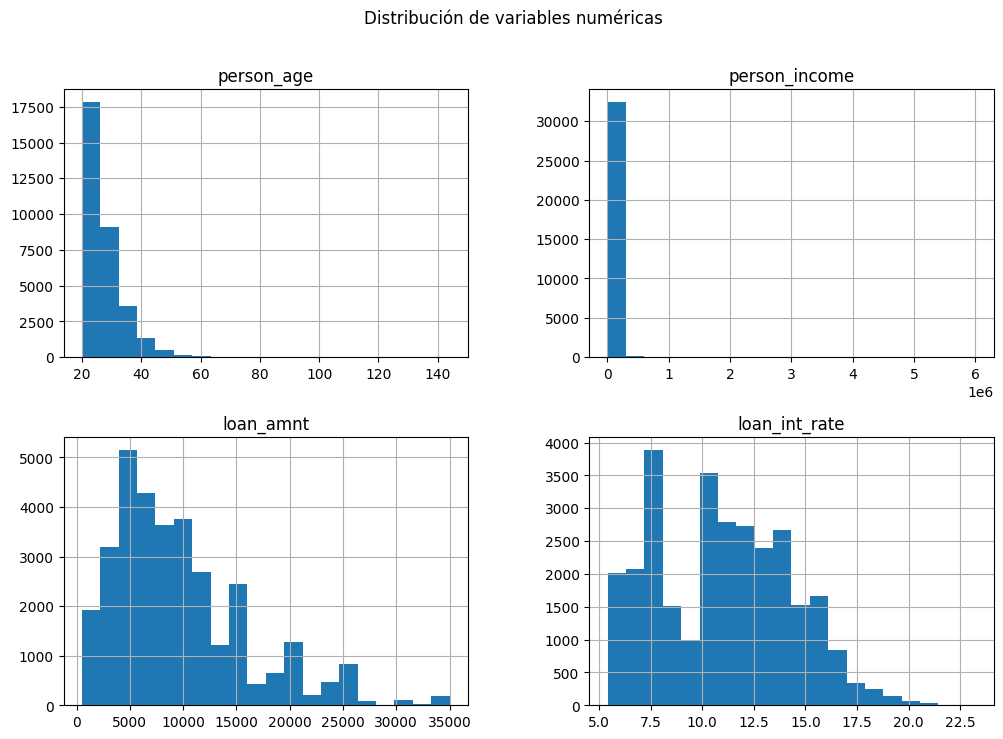

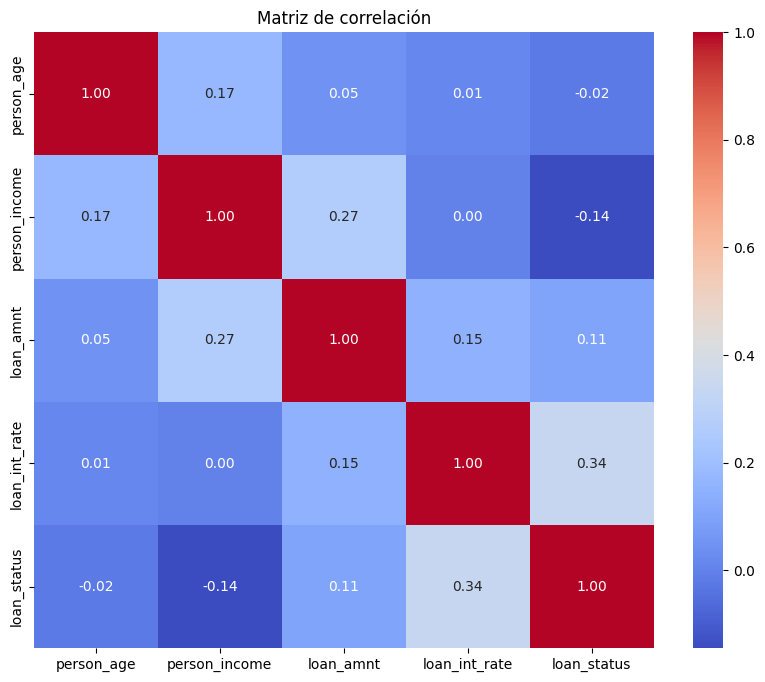

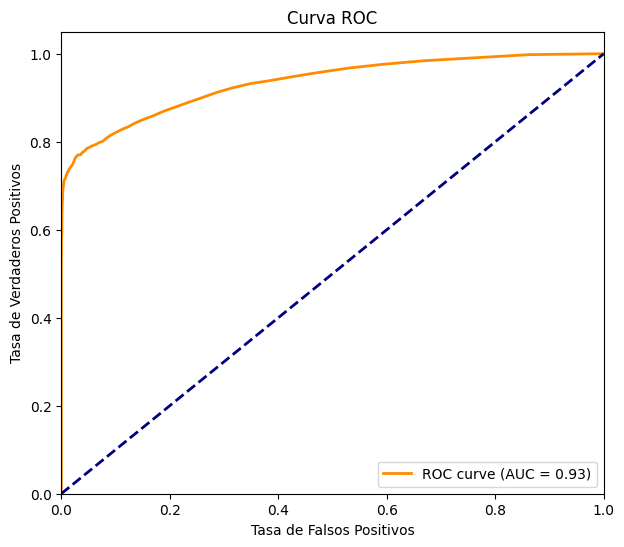

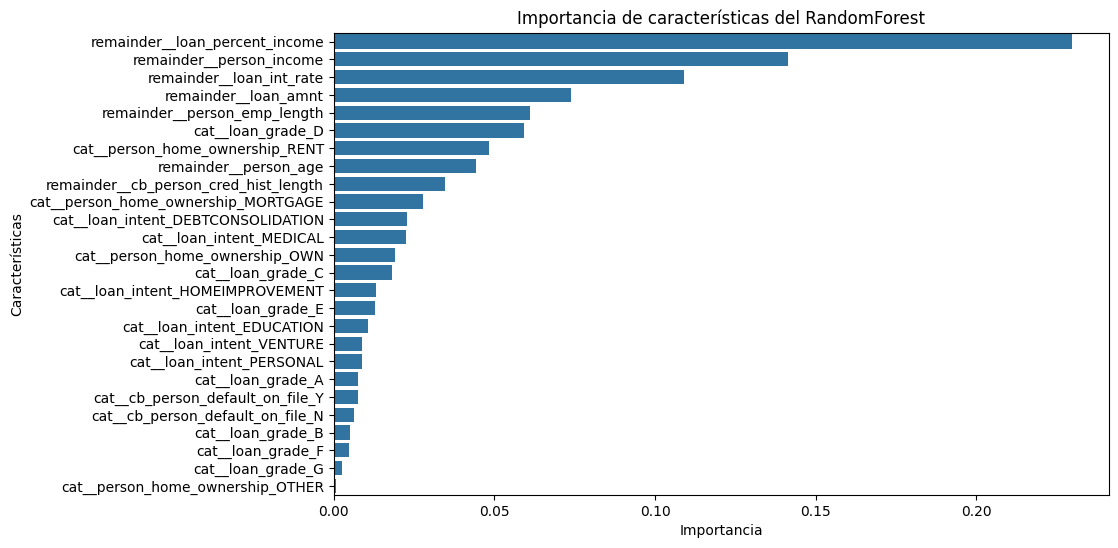

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# 1. Conteo de clases en la variable objetivo
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Distribución de la variable objetivo (loan_status)')
plt.xlabel('Loan Status')
plt.ylabel('Cantidad')
plt.show()

# 2. Histograma de algunas variables numéricas relevantes
num_cols = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate']
df[num_cols].hist(bins=20, figsize=(12,8))
plt.suptitle('Distribución de variables numéricas')
plt.show()

# 3. Matriz de correlación de variables numéricas
plt.figure(figsize=(10,8))
corr = df[num_cols + ['loan_status']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

# 4. Curva ROC y AUC del modelo RandomForest (suponiendo que y_test y y_pred_proba estén definidos)
y_pred_proba = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# 5. Importancia de variables del RandomForest
importances = pipeline.named_steps['classifier'].feature_importances_


feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
sorted_idx = importances.argsort()[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[sorted_idx], y=feature_names[sorted_idx])
plt.title('Importancia de características del RandomForest')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()
